<a href="https://colab.research.google.com/github/arjelmilan/Coding-DenseNet-/blob/main/DenseNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn

In [ ]:
class Bottleneck(nn.Module):
  # Creates a dense layer
  def __init__(self,in_channel,growth_rate):
    super().__init__()
    # 1*1 convolution layer consisting of BN-RELU-Conv
    self.bn1 = nn.BatchNorm2d(num_features = in_channel)
    self.relu = nn.ReLU()
    self.conv1 = nn.Conv2d(in_channels = in_channel,
                           out_channels = 4*growth_rate,
                           kernel_size = 1)

    self.bn2 = nn.BatchNorm2d(num_features = 4*growth_rate)
    self.relu = nn.ReLU()
    self.conv2 = nn.Conv2d(in_channels = 4*growth_rate,
                           out_channels = growth_rate,
                           kernel_size = 3,
                           padding = 1)

  def forward(self,x):
    out = self.conv1(self.relu(self.bn1(x)))
    out = self.conv2(self.relu(self.bn2(out)))

    out = torch.cat([x,out],dim=1)

    return out

class DenseBlock(nn.Module):
  def __init__(self,num_layers,in_channel,growth_rate):
    super().__init__()
    layers = []
    for i in range(num_layers):
      layers.append(Bottleneck(in_channel =in_channel + i*growth_rate ,
                               growth_rate = growth_rate))
    self.denseblock = nn.Sequential(*layers)

  def forward(self,x):
    return self.denseblock(x)




In [ ]:

class Transition(nn.Module):
  def __init__(self,in_channel,out_channel):
    super().__init__()
    self.bn = nn.BatchNorm2d(num_features = in_channel)
    self.relu = nn.ReLU()
    self.conv = nn.Conv2d(in_channels = in_channel,
                          out_channels = out_channel,
                          kernel_size = 1)
    self.pool = nn.AvgPool2d(kernel_size = 2,
                             stride = 2)

  def forward(self,x):
    x= self.pool(self.conv(self.relu(self.bn(x))))
    return x



In [ ]:
class DenseNet(nn.Module):
  def __init__(self,num_block:list,growth_rate:int=32,num_classes=1000):
    super().__init__()

    self.growth_rate = growth_rate

    self.relu = nn.ReLU()
    self.conv1 = nn.Conv2d(in_channels = 3,
                           out_channels = 2*growth_rate,
                           kernel_size = 7,
                           stride = 2,
                           padding = 3)
    self.bn1 = nn.BatchNorm2d(2*growth_rate)
    self.pool1 = nn.MaxPool2d(kernel_size = 3 ,
                              stride = 2)
    self.avgpool = nn.AdaptiveAvgPool2d((1,1))

    num_channels = 2*growth_rate
    #Dense Block 1
    self.dense1 = DenseBlock(num_block[0],num_channels,growth_rate)
    num_channels +=num_block[0]*growth_rate

    # Transition 1
    self.trans1 = Transition(num_channels,num_channels//2)
    num_channels = num_channels//2

    # Dense Block 2
    self.dense2 = DenseBlock(num_block[1],num_channels,growth_rate)
    num_channels +=num_block[1]*growth_rate

    # Transition 2
    self.trans2 = Transition(num_channels,num_channels//2)
    num_channels = num_channels//2

     # Dense Block 3
    self.dense3 = DenseBlock(num_block[2],num_channels,growth_rate)
    num_channels +=num_block[2]*growth_rate

    # Transition 3
    self.trans3 = Transition(num_channels,num_channels//2)
    num_channels = num_channels//2

     # Dense Block 4
    self.dense4 = DenseBlock(num_block[3],num_channels,growth_rate)
    num_channels +=num_block[3]*growth_rate

    self.bn2 = nn.BatchNorm2d(num_features = num_channels)
    self.fc = nn.Linear(num_channels,num_classes)

  def forward(self,x):
    x= self.pool1(self.relu(self.bn1(self.conv1(x))))

    x= self.dense1(x)
    x= self.trans1(x)

    x= self.dense2(x)
    x= self.trans2(x)

    x= self.dense3(x)
    x= self.trans3(x)

    x = self.dense4(x)
    x= self.relu(self.bn2(x))
    x = self.avgpool(x) # In adaptive pooling we specify the output size
    x = torch.flatten(x,1)
    x = self.fc(x)

    return x








In [ ]:

num_blocks = [6,12,24,16]
growth_rate = 32
DenseNet_model = DenseNet(num_blocks,growth_rate)

In [ ]:
!pip install torchview

In [ ]:
from torchview import draw_graph

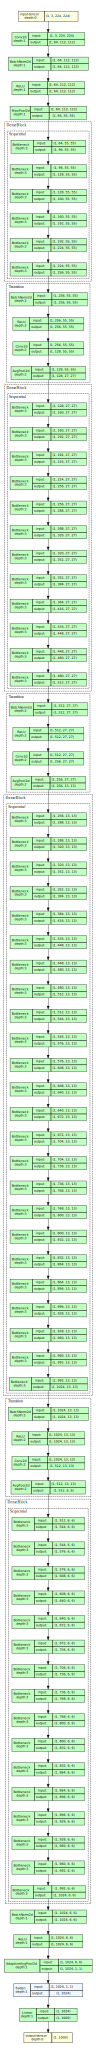

In [ ]:
draw_graph(DenseNet_model,input_size=(1,3,224,224),expand_nested = True).visual_graph

In [ ]:
!pip install torchinfo
from torchinfo import summary
summary(DenseNet_model,input_size=(1,3,224,224))

Layer (type:depth-idx)                   Output Shape              Param #
DenseNet                                 [1, 1000]                 --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,472
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 55, 55]           --
├─DenseBlock: 1-5                        [1, 256, 55, 55]          --
│    └─Sequential: 2-1                   [1, 256, 55, 55]          --
│    │    └─Bottleneck: 3-1              [1, 96, 55, 55]           45,600
│    │    └─Bottleneck: 3-2              [1, 128, 55, 55]          49,760
│    │    └─Bottleneck: 3-3              [1, 160, 55, 55]          53,920
│    │    └─Bottleneck: 3-4              [1, 192, 55, 55]          58,080
│    │    └─Bottleneck: 3-5              [1, 224, 55, 55]          62,240
│    │    └─Bottleneck: 3-6              [1, 256, 55, 55]    